In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [2]:
plt.rcdefaults()
plt.rcParams.update({'figure.dpi':100})
#plt.rcParams.update({'figure.autolayout':'True'})
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })
plt.rc('legend',**{'fontsize':'x-small'})
#plt.figure(1,figsize = [11.0, 8.5])
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':'True'})
plt.rcParams.update({'ytick.right':'True'})
plt.rcParams.update({'axes.formatter.limits': (-2, 2)})
plt.rcParams.update({'lines.markersize': 8}) #6 is the default
plt.rcParams.update({'legend.framealpha': 1.0})
plt.rcParams.update({'legend.fancybox': 'False'})
#plt.rcParams.update({'axes.grid':'True'})

In [3]:
# Global variables
Percentages = [0.6827, 0.9545]
d = 3

In [8]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return ((1/(np.sqrt(((2*np.pi)**d)*np.linalg.det(covariance))))*
            np.exp(-((x_m.T)@np.linalg.inv(covariance)@(x_m))/2))

def generate_surface(mean, covariance, d, n_x, n_y, n_z):
    """Helper function to generate density surface."""
    xs = np.linspace(-5, 5, num=n_x)
    ys = np.linspace(-5, 5, num=n_y)
    zs = np.linspace(-5, 5, num=n_z)
    x, y, z = np.meshgrid(xs, ys, zs) # Generate grid
    pdf = np.zeros((n_x, n_y, n_z))
    # Fill the cost matrix for each combination of weights
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                pdf[i,j,k] = multivariate_normal(
                    np.matrix([[x[i,j,k]], [y[i,j,k]], [z[i,j,k]]]), 
                    d, mean, covariance)
    return x, y, z, pdf  # x1, x2, pdf(x1,x2)

In [20]:
mu_p, mu_a, mu_b = 0.3, 0.5, 0.2
sigma_p, sigma_a, sigma_b = 1.1, 1, 1.2
alpha_1, alpha_2, alpha_3 = 0, 0, 0
n_p, n_a, n_b = 101, 101, 101

mu = np.matrix([[mu_p], [mu_a], [mu_b]])  # Mean
cov = np.matrix([[(sigma_p**2), alpha_1, alpha_2],
                 [alpha_1, (sigma_a**2), alpha_3],
                 [alpha_2, alpha_3, (sigma_b**2)]])  # Covariance

P, A, B, L = generate_surface(mu, cov, d, n_p, n_a, n_b) # B and P are meshgrid variables
p = P[0].T[0]
a = A.T[0][0]
b = B[0][0]

Marginalize: Sum over $b$, normalize result to 1

Maximize: Taking a slice of $L$ at $b=\mathrm{mean}_b$, normalize result to 1

In [43]:
L0 = np.sum(L, axis=0)
L1 = np.sum(L, axis=1)
L2 = np.sum(L, axis=2)

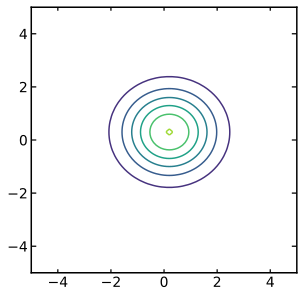

In [48]:
fig, ax = plt.subplots(1, 1)
ax.contour(p, a, L0)
ax.set_aspect('equal')
# axis = 0 summed over a
# axis = 1 summed over p
# axis = 2 summed over b
# I want to sum over a and b (0 and 2)

In [54]:
L_axis = np.sum(L0, axis=1)

In [57]:
L_p = normalize(L_axis, p)

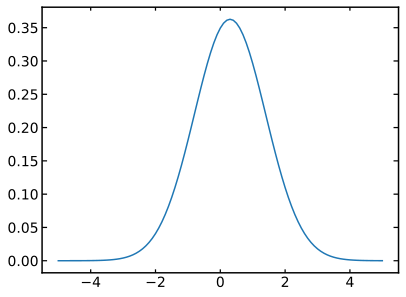

In [58]:
fig, ax = plt.subplots(1, 1)
ax.plot(p, L_p)

In [56]:
def normalize(l, x):
    raw_sum = np.trapz(l, x)
    return l/raw_sum

# marginalize over param y for axis = 0,
#                        x for axis = 1
# a denotes x or y
def marginalize(L, a, axis):
    l_axis = np.sum(L, axis=axis)
    l_normed = normalize(l_axis, a)
    return l_normed

# maximize over param y
def maximize(L, x, y, mean_y):
    pos = np.where(y==mean_y)[0][0]
    l = L[pos]
    return normalize(l, x)

In [ ]:
def get_levels(likelihood, percentages):
    l_flatten = likelihood.flatten()
    l_flatten.sort()
    l_dec = l_flatten[::-1]
    l_tot = np.sum(l_dec)
    levels = []
    l_sum = 0
    i = -1
    for percentage in percentages:
        while((l_sum/l_tot)<percentage):
            i += 1
            l_sum += l_dec[i]
        levels.append(l_dec[i])
    return levels[::-1]

In [ ]:
# 3 subplots Method 2
def likelihood_plot(x, y, mean_y, L, ax, ax_px, ax_py, levels):
    # no labels
    ax_px.tick_params(axis="x", labelbottom=False)
    ax_py.tick_params(axis="y", labelleft=False)

    # the contour plot:
    # change to proper plot
    ax.contourf(x, y, L, levels=levels, 
                colors=('w', 'mistyrose', 'salmon'),
                alpha=0.5,
                extend='both')
    
    Lx = marginalize(L, x, 0)
    Lx_max = maximize(L, x, y, mean_y)
    max_x = x[np.argmax(Lx)]
    ax_px.plot(x, Lx, label='Marginalize')
    ax_px.plot(x, Lx_max, 'r--', label='Maximize')
    ax_px.axvline(max_x, color="grey", linestyle="--")
    ax_px.legend()
    ax.axvline(max_x, color="grey", linestyle="--", label='{:.2f}'.format(max_x))
    
    Ly = marginalize(L, y, 1)
    Ly = np.sum(L, axis=1)
    max_y = y[np.argmax(Ly)]
    ax_py.plot(Ly, y)
    ax_py.axhline(max_y, color="grey", linestyle=":")
    ax.axhline(max_y, color="grey", linestyle=":", label='{:.2f}'.format(max_y))
    
    ax.legend()

In [ ]:
mu_p, mu_b = 0.3, 0.5
sigma_p, sigma_b = 1.1, 1
alpha = 0.5
n_row, n_col = 101, 101

mu = np.matrix([[mu_p], [mu_b]])  # Mean
cov = np.matrix([[(sigma_p**2), alpha], 
                 [alpha, (sigma_b**2)]])  # Covariance

P, B, L = generate_surface(mu, cov, d, n_row, n_col) # B and P are meshgrid variables
p = P[0]
b = B.T[0]

In [ ]:
def run(d, mu_p, mu_b, sigma_p, sigma_b, alpha, n_row, n_col):
    # generate space and likelihood
    mu = np.matrix([[mu_p], [mu_b]])  # Mean
    cov = np.matrix([[(sigma_p**2), alpha], 
                     [alpha, (sigma_b**2)]])  # Covariance
    
    P, B, L = generate_surface(mu, cov, d, n_row, n_col) # B and P are meshgrid variables
    p = P[0]
    b = B.T[0]
    Levels = get_levels(L, Percentages)
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0

    Likelihood = [left, bottom, width, height]
    pp = [left, bottom + height + spacing, width, 0.2]
    pb = [left + width + spacing, bottom, 0.2, height]

    fig = plt.figure(figsize=(5, 5))

    ax = fig.add_axes(Likelihood)
    ax.set_xlabel('p')
    ax.set_ylabel('b')

    ax_px = fig.add_axes(pp, sharex=ax)
    ax_px.set_ylabel('P(p)')
    #ax_px.plot(p, L_p, 'k.', markersize=5)
    #ax_px.plot(p, L_p_max, 'g.', markersize=5)

    ax_py = fig.add_axes(pb, sharey=ax)
    ax_py.set_xlabel('P(b)')

    # use the previously defined function
    likelihood_plot(p, b, mu_b, L, ax, ax_px, ax_py, Levels)

    #ax_px.set_title(r'$\alpha={}$'.format(alpha))

    plt.show()